# Task1   Data Acquisition

In [1]:
import os
import csv
import urllib
import json

import pandas as pd
import numpy as np
import datetime
from alpha_vantage.timeseries import TimeSeries
from covid19dh import covid19
import requests
import matplotlib.pyplot as plt
import dataframe_image as dfi
import pickle
import seaborn as sn
from scipy import stats
from matplotlib.ticker import MultipleLocator

import time

In [2]:
api_key='B1Q551T88OEDZJ52'

# stock data for APPLE

In [19]:
ts = TimeSeries (key=api_key, output_format = "pandas")
data_daily, meta_data = ts.get_daily_adjusted(symbol='AAPL', outputsize ='full')

start_date = datetime.datetime(2017, 4, 1)
end_date = datetime.datetime(2022, 4, 30)

# Create a filtered dataframe, and change the order it is displayed. 
stock_data = data_daily[(data_daily.index > start_date) & (data_daily.index <= end_date)]
stock_data = stock_data.sort_index(ascending=True)
#date_filter
stock_data = stock_data.rename(columns={'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Original Close',
                                '5. adjusted close': 'Close', '6. volume': 'Volume', '7. dividend amount': 'Dividend',
                                '8. split coefficient': 'Split'})
stock_data


,Open,High,Low,Original Close,Close,Volume,Dividend,Split
date,,,,,,,,
2017-04-03,143.71,144.120,143.05,143.70,33.718447,19985714.0,0.0,1.0
2017-04-04,143.25,144.890,143.17,144.77,33.969517,19891354.0,0.0,1.0
2017-04-05,144.22,145.460,143.81,144.02,33.793534,27717854.0,0.0,1.0
2017-04-06,144.29,144.520,143.45,143.66,33.709062,21149034.0,0.0,1.0
2017-04-07,143.73,144.180,143.27,143.34,33.633975,16658543.0,0.0,1.0
...,...,...,...,...,...,...,...,...
2022-04-25,161.12,163.170,158.46,162.88,161.942007,96046376.0,0.0,1.0
2022-04-26,162.25,162.340,156.72,156.80,155.897020,94008394.0,0.0,1.0
2022-04-27,155.91,159.790,155.38,156.57,155.668345,88063191.0,0.0,1.0


# Stock data for SSNLF

In [4]:
ts = TimeSeries (key=api_key, output_format = "pandas")
data_daily, meta_data = ts.get_daily_adjusted(symbol='SSNLF', outputsize ='full')

start_date = datetime.datetime(2017, 4, 1)
end_date = datetime.datetime(2022, 4, 30)

# Create a filtered dataframe, and change the order it is displayed. 
stock_data_SSNLF = data_daily[(data_daily.index > start_date) & (data_daily.index <= end_date)]
stock_data_SSNLF = stock_data_SSNLF.sort_index(ascending=True)
#date_filter
stock_data_SSNLF = stock_data_SSNLF.rename(columns={'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Original Close',
                                '5. adjusted close': 'Close', '6. volume': 'Volume', '7. dividend amount': 'Dividend',
                                '8. split coefficient': 'Split'})
stock_data_SSNLF

,Open,High,Low,Original Close,Close,Volume,Dividend,Split
date,,,,,,,,
2017-04-03,1500.00,1500.00,1500.00,1500.00,29.587798,7.0,0.0,1.0
2017-04-04,1500.00,1500.00,1500.00,1500.00,29.587798,20.0,0.0,1.0
2017-04-05,1500.00,1500.00,1500.00,1500.00,29.587798,0.0,0.0,1.0
2017-04-06,1500.00,1500.00,1500.00,1500.00,29.587798,0.0,0.0,1.0
2017-04-07,1500.00,1500.00,1500.00,1500.00,29.587798,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
2022-04-25,57.75,57.75,57.75,57.75,57.750000,0.0,0.0,1.0
2022-04-26,57.75,57.75,57.75,57.75,57.750000,0.0,0.0,1.0
2022-04-27,57.75,57.75,57.75,57.75,57.750000,0.0,0.0,1.0


In [5]:
datasets_dir='./Datasets'
stock_filename='AAPL_stock_data'
stock_data.to_pickle(os.path.join(datasets_dir, f'{stock_filename}.pkl'))
stock_data.to_csv(os.path.join(datasets_dir, f'{stock_filename}.csv'))

In [6]:
stock_filename_SSNLF='SSNLF_stock_data'
stock_data_SSNLF.to_pickle(os.path.join(datasets_dir, f'{stock_filename_SSNLF}.pkl'))
stock_data_SSNLF.to_csv(os.path.join(datasets_dir, f'{stock_filename_SSNLF}.csv'))

# Covid Data

In [46]:
df_covid,src=covid19('USA',start=start_date,end=end_date,verbose = False)
covid_filename='Covid'
df_covid.to_pickle(os.path.join(datasets_dir, f'{covid_filename}.pkl'))
df_covid.to_csv(os.path.join(datasets_dir, f'{covid_filename}.csv'))

# Weather Data

In [10]:
from meteostat import Point
from meteostat import Daily
location = Point(37.323,-122.032,70)
data = Daily(location, start_date, end_date)
weather_filename='Cupertino_weather_2017_22'
cupertino_weather = data.fetch()
cupertino_weather.to_csv(os.path.join(datasets_dir, f'{weather_filename}.csv'))
cupertino_weather.to_pickle(os.path.join(datasets_dir, f'{weather_filename}.pkl'))

# Task3 Data Preprocessing

In [12]:
pdates = pd.date_range(start=start_date, end=end_date)
preprocessed_path='./Preprocessed'

In [104]:
stock_pre_filename='AAPL_stock_data_pre'
#stock_time_series=stock_data['Close']
stock_pre=stock_data.drop(['Open','High','Low','Original Close','Volume','Dividend','Split'],axis=1)
print(stock_pre) #dataframe
stock_pre_nan=stock_pre.reindex(pdates, fill_value=np.nan)
print(stock_pre_nan) #dataframe

<class 'pandas.core.frame.DataFrame'>
                 Close
2017-04-01         NaN
2017-04-02         NaN
2017-04-03   33.718447
2017-04-04   33.969517
2017-04-05   33.793534
...                ...
2022-04-26  155.897020
2022-04-27  155.668345
2022-04-28  162.697630
2022-04-29  156.742125
2022-04-30         NaN

[1856 rows x 1 columns]


In [26]:
stock_pre_nan.to_csv(os.path.join(preprocessed_path,f'{stock_pre_filename}.csv'))
stock_pre_nan.to_pickle(os.path.join(preprocessed_path,f'{stock_pre_filename}.pkl'))

In [110]:
covid_pre_filename='covid_pre'
#stock_time_series=stock_data['Close']
covid_pre=df_covid[['date', 'confirmed']]
covid_pre.set_index('date',inplace=True)
covid_pre_nan=covid_pre.reindex(pdates,fill_value=np.nan)
covid_pre_nan

,confirmed
2017-04-01,NaN
2017-04-02,NaN
2017-04-03,NaN
2017-04-04,NaN
2017-04-05,NaN
...,...
2022-04-26,80996837.0
2022-04-27,81081307.0
2022-04-28,81154876.0
2022-04-29,81236707.0


In [112]:
covid_pre_nan_filename='covid_pre_nan'
covid_pre_nan.to_csv(os.path.join(preprocessed_path,f'{covid_pre_nan_filename}.csv'))
covid_pre_nan.to_pickle(os.path.join(preprocessed_path,f'{covid_pre_nan_filename}.pkl'))

In [142]:
covid_pre_0=covid_pre.reindex(pdates,fill_value=0)
covid_pre_0["daily_confirmed"] = np.insert(np.diff(covid_pre_0.values.flatten()), 0, 0)
covid_daily_pre_0=covid_pre_0[['daily_confirmed']]
type(covid_daily_pre_0)

pandas.core.frame.DataFrame

In [85]:
covid_daily_pre_0.to_csv(os.path.join(preprocessed_path,f'{covid_pre_filename}.csv'))
covid_daily_pre_0.to_pickle(os.path.join(preprocessed_path,f'{covid_pre_filename}.pkl'))

# Weather Data

In [86]:
cupertino_weather

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2017-04-01,17.4,9.7,25.3,0.0,0.0,NaN,7.5,NaN,1015.7,NaN
2017-04-02,16.8,10.3,24.7,0.0,0.0,NaN,10.2,NaN,1015.3,NaN
2017-04-03,15.4,9.7,21.9,0.0,0.0,NaN,11.8,NaN,1014.9,NaN
2017-04-04,15.2,7.5,23.0,0.0,0.0,NaN,8.7,NaN,1016.5,NaN
2017-04-05,17.4,11.9,24.1,0.0,0.0,NaN,8.4,NaN,1016.3,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-04-26,14.4,10.8,19.1,0.0,NaN,357.0,13.1,NaN,1016.6,NaN
2022-04-27,12.8,6.9,19.1,0.0,NaN,329.0,13.8,NaN,1016.6,NaN
2022-04-28,12.8,8.6,17.5,0.0,NaN,320.0,17.4,NaN,1019.0,NaN


In [88]:
weather_pre_filename='weather_pre'
weather_pre=cupertino_weather.drop(['wpgt','snow','tsun','pres','wdir'],axis=1)
weather_pre


,tavg,tmin,tmax,prcp,wspd
time,,,,,
2017-04-01,17.4,9.7,25.3,0.0,7.5
2017-04-02,16.8,10.3,24.7,0.0,10.2
2017-04-03,15.4,9.7,21.9,0.0,11.8
2017-04-04,15.2,7.5,23.0,0.0,8.7
2017-04-05,17.4,11.9,24.1,0.0,8.4
...,...,...,...,...,...
2022-04-26,14.4,10.8,19.1,0.0,13.1
2022-04-27,12.8,6.9,19.1,0.0,13.8
2022-04-28,12.8,8.6,17.5,0.0,17.4


In [145]:
weather_pre=weather_pre.fillna(0)
weather_pre.to_csv(os.path.join(preprocessed_path,f'{weather_pre_filename}.csv'))
weather_pre.to_pickle(os.path.join(preprocessed_path,f'{weather_pre_filename}.pkl'))

In [144]:
covid_time_fill=covid_daily_pre_0.index.values
print(covid_time_fill)

['2017-04-01T00:00:00.000000000' '2017-04-02T00:00:00.000000000'
 '2017-04-03T00:00:00.000000000' ... '2022-04-28T00:00:00.000000000'
 '2022-04-29T00:00:00.000000000' '2022-04-30T00:00:00.000000000']


In [155]:
covid_daily_pre_0
covid_np=covid_daily_pre_0['daily_confirmed'].to_numpy()
covid_np.shape

(1856,)

# Z-score

z score of the (filled) covid dataset is:
 [0.4020704  0.4020704  0.4020704  ... 0.27355081 0.34942492 0.19703949]


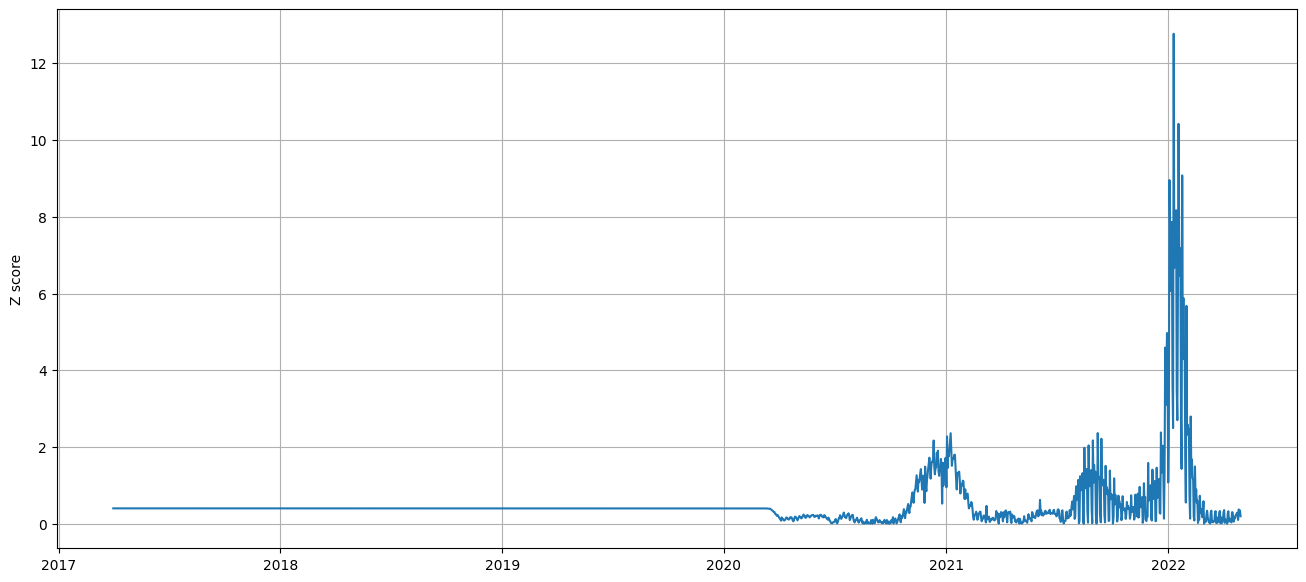

In [156]:
from scipy import stats
# calculate the absolute value of z-score
z_covid = np.abs(stats.zscore(covid_np))
print('z score of the (filled) covid dataset is:\r\n',z_covid)
plt.figure(figsize=(16,7))
plt.plot(covid_time_fill,z_covid)
plt.grid()
#plt.xlim([datetime.datetime(), end_date])
plt.ylabel('Z score')
plt.show()

In [157]:
stock_pre_nan

,Close
2017-04-01,NaN
2017-04-02,NaN
2017-04-03,33.718447
2017-04-04,33.969517
2017-04-05,33.793534
...,...
2022-04-26,155.897020
2022-04-27,155.668345
2022-04-28,162.697630
2022-04-29,156.742125


In [158]:
weather_pre

,tavg,tmin,tmax,prcp,wspd
2017-04-01,17.4,9.7,25.3,0.0,7.5
2017-04-02,16.8,10.3,24.7,0.0,10.2
2017-04-03,15.4,9.7,21.9,0.0,11.8
2017-04-04,15.2,7.5,23.0,0.0,8.7
2017-04-05,17.4,11.9,24.1,0.0,8.4
...,...,...,...,...,...
2022-04-26,14.4,10.8,19.1,0.0,13.1
2022-04-27,12.8,6.9,19.1,0.0,13.8
2022-04-28,12.8,8.6,17.5,0.0,17.4
2022-04-29,14.3,6.9,23.0,0.0,11.1


In [159]:
covid_daily_pre_0

,daily_confirmed
2017-04-01,0.0
2017-04-02,0.0
2017-04-03,0.0
2017-04-04,0.0
2017-04-05,0.0
...,...
2022-04-26,54653.0
2022-04-27,84470.0
2022-04-28,73569.0
2022-04-29,81831.0


['2017-04-03T00:00:00.000000000' '2017-04-04T00:00:00.000000000'
 '2017-04-05T00:00:00.000000000' ... '2022-04-27T00:00:00.000000000'
 '2022-04-28T00:00:00.000000000' '2022-04-29T00:00:00.000000000']
[ 33.71844731  33.96951717  33.79353362 ... 155.66834473 162.69763002
 156.74212523]
z score of the dataset is:
 [1.04407211 1.03853806 1.04241707 ... 1.64393417 1.79887291 1.66760233]


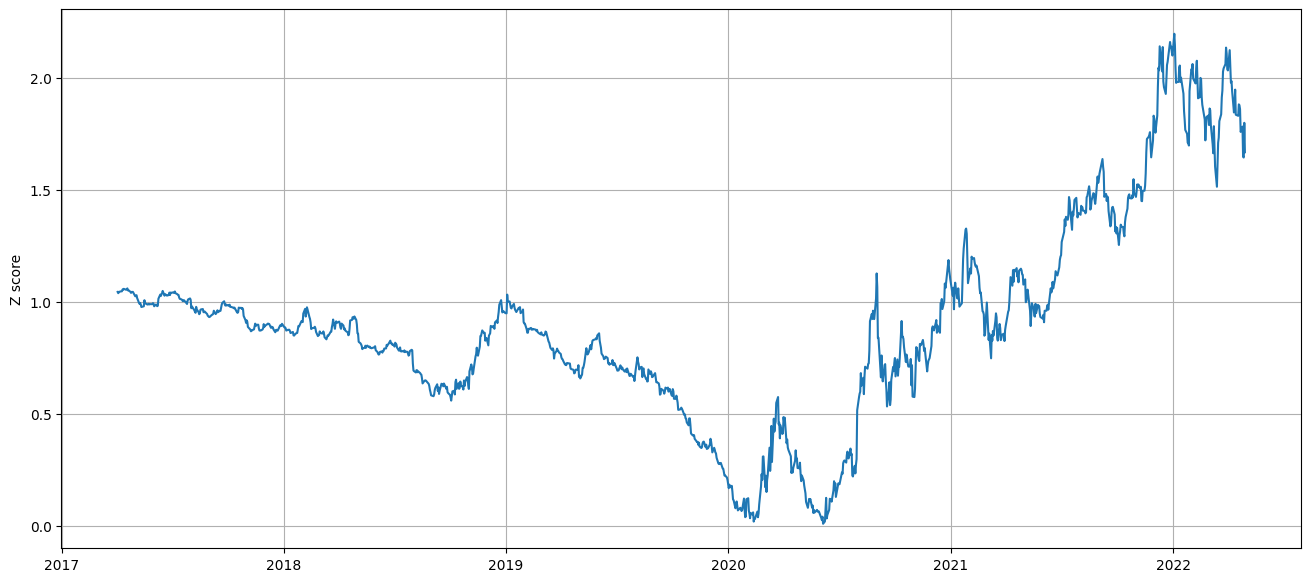

In [166]:
stock_np=stock_data[['Close']].to_numpy().flatten()
stock_time=stock_pre.index.values
print(stock_time)
# stock=stock.to_numpy().flatten()
print(stock_np)

z_stock = np.abs(stats.zscore(stock_np))
print('z score of the dataset is:\r\n',z_stock)
plt.figure(figsize=(16,7))
plt.plot(stock_time,z_stock)
plt.grid()
#plt.xlim([datetime.datetime(), end_date])
plt.ylabel('Z score')
plt.show()

# Outlier

In [167]:
# set a threshold and find the location where the value meets our condition(s)
threshold = 3
covid_outlier_loc = np.where(z_covid > threshold)

# find the outlier value given its index
covid_outlier_by_Z_Score = z_covid[covid_outlier_loc]
print('the data classified as outlier by z score:\r\n', covid_outlier_by_Z_Score)
print('the datetime of the outlier is:\r\n', covid_time_fill[covid_outlier_loc])

the data classified as outlier by z score:
 [ 4.58953138  3.09419979  4.08925082  4.97078455  3.69897945  8.95532328
  7.73365092  6.06370418  6.57021117  7.86464443  3.69597644 12.76686316
  6.66856649  7.68843135  7.57570384  8.16913269  3.48463646  6.13705283
 10.4197983   7.42186178  6.47012934  7.17721323  9.07676594  4.2899012
  5.8835422   4.46761118  4.70189156  5.67715213]
the datetime of the outlier is:
 ['2021-12-27T00:00:00.000000000' '2021-12-28T00:00:00.000000000'
 '2021-12-29T00:00:00.000000000' '2021-12-30T00:00:00.000000000'
 '2021-12-31T00:00:00.000000000' '2022-01-03T00:00:00.000000000'
 '2022-01-04T00:00:00.000000000' '2022-01-05T00:00:00.000000000'
 '2022-01-06T00:00:00.000000000' '2022-01-07T00:00:00.000000000'
 '2022-01-08T00:00:00.000000000' '2022-01-10T00:00:00.000000000'
 '2022-01-11T00:00:00.000000000' '2022-01-12T00:00:00.000000000'
 '2022-01-13T00:00:00.000000000' '2022-01-14T00:00:00.000000000'
 '2022-01-15T00:00:00.000000000' '2022-01-17T00:00:00.00000000

# Box Plot

[ 33.71844731  33.96951717  33.79353362 ... 155.66834473 162.69763002
 156.74212523]
['2017-04-03T00:00:00.000000000' '2017-04-04T00:00:00.000000000'
 '2017-04-05T00:00:00.000000000' ... '2022-04-27T00:00:00.000000000'
 '2022-04-28T00:00:00.000000000' '2022-04-29T00:00:00.000000000']


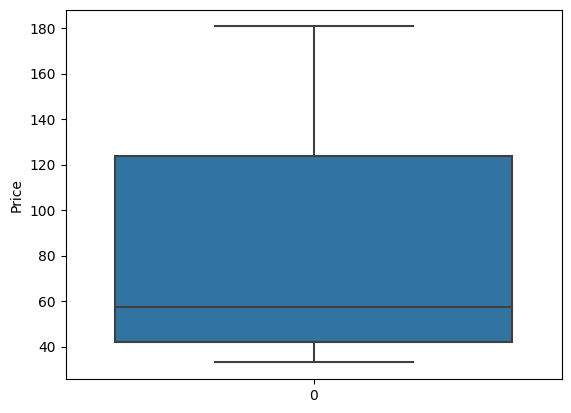

In [168]:
import seaborn as sns

# extract all the data except the last one because it is a NaN, which is missing value. 
# We will see shortly how to deal with missing value.
outlier_dataset_stock = stock_np
print(outlier_dataset_stock)
#print('\n')
outlier_date_stock = np.array(stock_time)
print(outlier_date_stock)
# box plot
sns.boxplot(outlier_dataset_stock)
plt.ylabel(r'Price')
plt.show()

[    0.     0.     0. ... 73569. 81831. 22326.]
['2017-04-01T00:00:00.000000000' '2017-04-02T00:00:00.000000000'
 '2017-04-03T00:00:00.000000000' ... '2022-04-28T00:00:00.000000000'
 '2022-04-29T00:00:00.000000000' '2022-04-30T00:00:00.000000000']


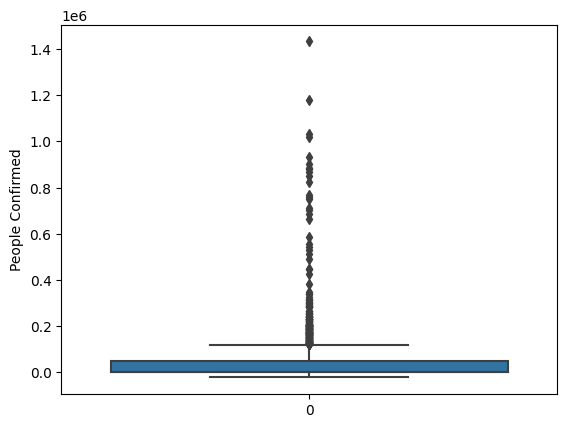

In [169]:
import seaborn as sns
# extract all the data except the last one because it is a NaN, which is missing value. 
# We will see shortly how to deal with missing value.
outlier_dataset_covid = covid_np
print(outlier_dataset_covid)
#print('\n')
outlier_date_covid = covid_time_fill
print(outlier_date_covid)
# box plot
sns.boxplot(outlier_dataset_covid)
plt.ylabel(r'People Confirmed')
plt.show()

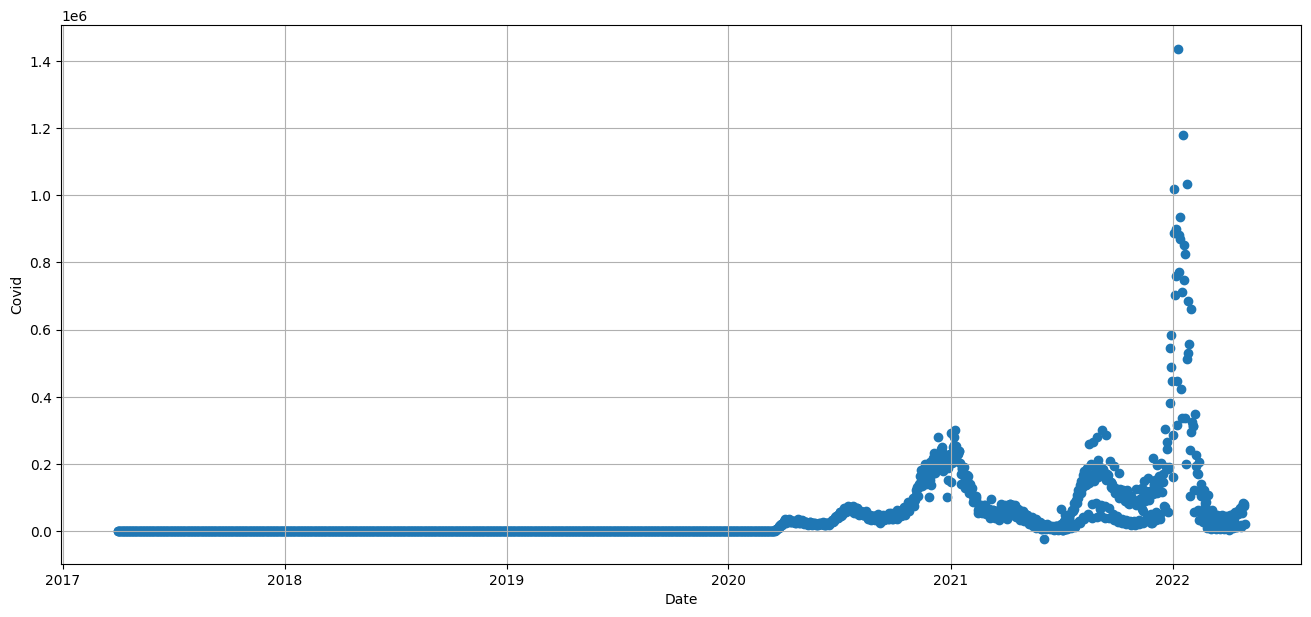

In [170]:
plt.figure(figsize=(16,7))
plt.scatter(outlier_date_covid,outlier_dataset_covid)
plt.xlabel('Date')
plt.ylabel('Covid')
plt.grid()
plt.show()

# Cap

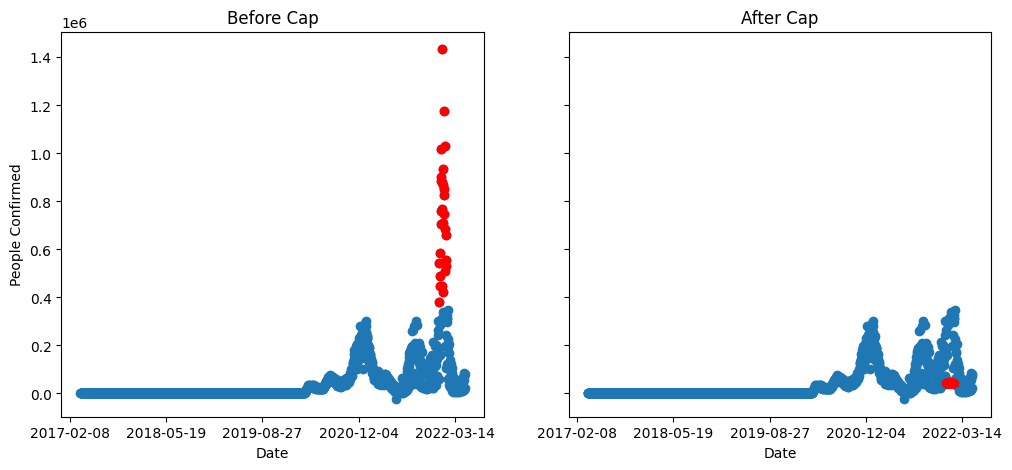

In [175]:
capped_outlier_dataset = np.copy(outlier_dataset_covid)
capped_outlier_dataset[covid_outlier_loc] = np.mean(capped_outlier_dataset)


# Plot and compare, before and after the outlier is capped.
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(12, 5))
ax1.set_title("Before Cap")
ax1.scatter(outlier_date_covid, outlier_dataset_covid)
ax1.scatter(outlier_date_covid[covid_outlier_loc], outlier_dataset_covid[covid_outlier_loc], c = 'r')
ax1.set_xlabel("Date")
ax1.set_ylabel("People Confirmed")
ax1.xaxis.set_major_locator(MultipleLocator(465)) # Spacing of axis tickers.

ax2.set_title("After Cap")
ax2.scatter(outlier_date_covid, capped_outlier_dataset)
ax2.scatter(outlier_date_covid[covid_outlier_loc], capped_outlier_dataset[covid_outlier_loc], c = 'r')
ax2.set_xlabel("Date")
ax2.xaxis.set_major_locator(MultipleLocator(465)) # Spacing of axis tickers.

# Merge

In [176]:
covid_pre_nan

,confirmed
2017-04-01,NaN
2017-04-02,NaN
2017-04-03,NaN
2017-04-04,NaN
2017-04-05,NaN
...,...
2022-04-26,80996837.0
2022-04-27,81081307.0
2022-04-28,81154876.0
2022-04-29,81236707.0


In [178]:
weather_pre

,tavg,tmin,tmax,prcp,wspd
2017-04-01,17.4,9.7,25.3,0.0,7.5
2017-04-02,16.8,10.3,24.7,0.0,10.2
2017-04-03,15.4,9.7,21.9,0.0,11.8
2017-04-04,15.2,7.5,23.0,0.0,8.7
2017-04-05,17.4,11.9,24.1,0.0,8.4
...,...,...,...,...,...
2022-04-26,14.4,10.8,19.1,0.0,13.1
2022-04-27,12.8,6.9,19.1,0.0,13.8
2022-04-28,12.8,8.6,17.5,0.0,17.4
2022-04-29,14.3,6.9,23.0,0.0,11.1


In [179]:
stock_pre_nan

,Close
2017-04-01,NaN
2017-04-02,NaN
2017-04-03,33.718447
2017-04-04,33.969517
2017-04-05,33.793534
...,...
2022-04-26,155.897020
2022-04-27,155.668345
2022-04-28,162.697630
2022-04-29,156.742125


In [182]:
new = pd.concat([stock_pre_nan, covid_pre_nan, weather_pre], axis=1, join='outer')
new

,Close,confirmed,tavg,tmin,tmax,prcp,wspd
2017-04-01,NaN,NaN,17.4,9.7,25.3,0.0,7.5
2017-04-02,NaN,NaN,16.8,10.3,24.7,0.0,10.2
2017-04-03,33.718447,NaN,15.4,9.7,21.9,0.0,11.8
2017-04-04,33.969517,NaN,15.2,7.5,23.0,0.0,8.7
2017-04-05,33.793534,NaN,17.4,11.9,24.1,0.0,8.4
...,...,...,...,...,...,...,...
2022-04-26,155.897020,80996837.0,14.4,10.8,19.1,0.0,13.1
2022-04-27,155.668345,81081307.0,12.8,6.9,19.1,0.0,13.8
2022-04-28,162.697630,81154876.0,12.8,8.6,17.5,0.0,17.4
2022-04-29,156.742125,81236707.0,14.3,6.9,23.0,0.0,11.1
